In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
def find_points(img_path):
    nx=9
    ny=6
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    return ret,corners


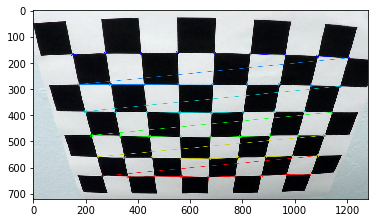

In [3]:
#find_points('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
img=cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
cv2.drawChessboardCorners(img, (9, 6), corners, ret)
plt.imshow(img)

In [4]:
gray.shape[::-1]

(1280, 720)

In [4]:
def find_points_all_images(dir):
    img_paths=glob.glob(dir + '/' + '*.jpg')
    img_points=[]
    obj_points=[]
    objp=np.zeros((6*9,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    for img_path in img_paths:
        ret,corners = find_points(img_path)
       
        if ret:
            obj_points.append(objp)
            img_points.append(corners)
    return obj_points,img_points
        
    

In [5]:
obj_points,img_points = find_points_all_images('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal')

In [6]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(obj_points,img_points,(1280,720),None,None)

In [8]:
undistorted_image = cv2.undistort(cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'),mtx,dist,None,mtx)

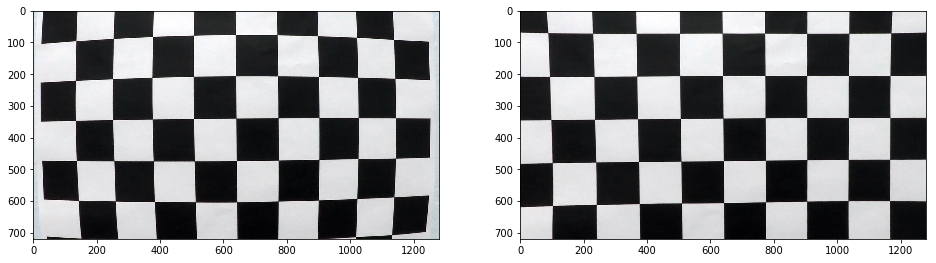

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'))
plt.subplot(1,2,2)
plt.imshow(undistorted_image)

In [7]:
def undistort_image(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

In [8]:
#from lecture_notes
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255,sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    

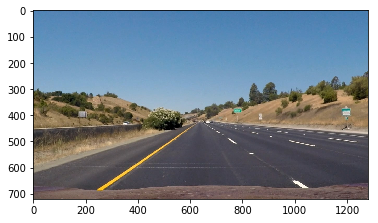

In [12]:
test_image=cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))

In [13]:
#play around a little with thresholds to see the impact

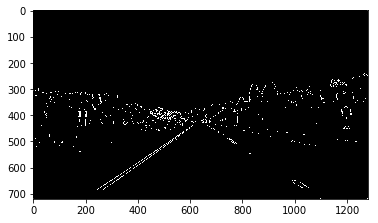

In [14]:
binary_image=abs_sobel_thresh(test_image,thresh_min=45, thresh_max=150)
plt.imshow(binary_image,cmap='gray')

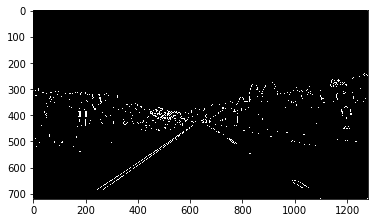

In [15]:
binary_image=abs_sobel_thresh(test_image,thresh_min=45, thresh_max=200)
plt.imshow(binary_image,cmap='gray')

In [9]:
# from lecture notes
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

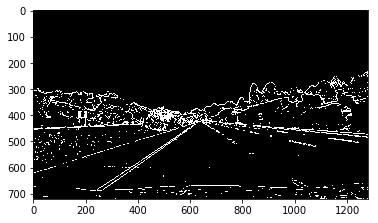

In [17]:
binary_image = mag_thresh(test_image,mag_thresh=(30,200))
plt.imshow(binary_image,cmap='gray')
# not much can be gleaned from just mag_thresh..only a combination with direction can generate useful results

In [10]:
#from lecture notes
def direction_threshold(img,sobel_kernel=3,thresh=(0,np.pi/2.0)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    

In [11]:
def mag_and_dir(img,sobel_kernel=3,mag_threshold=(30,150),dir_thresh=(0.7,1.3)):
    mag_binary=mag_thresh(img,sobel_kernel=sobel_kernel,mag_thresh=mag_threshold)
    dir_binary=direction_threshold(img,sobel_kernel=sobel_kernel,thresh=dir_thresh)
    composite_binary = np.zeros_like(dir_binary)
    composite_binary[(mag_binary==1) &(dir_binary==1) ]=1
    return composite_binary


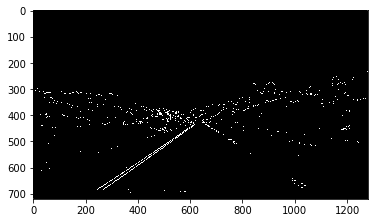

In [20]:
binary_image=mag_and_dir(test_image,mag_threshold=(45,200),dir_thresh=(0.7,1.3))
plt.imshow(binary_image,cmap='gray')

In [12]:
def compose_all_gray_gradients(img,sobel_kernel=3):
    gradx = abs_sobel_thresh(img,orient='x',thresh_min=30,thresh_max=150,sobel_kernel=sobel_kernel)
    grady = abs_sobel_thresh(img,orient='y',thresh_min=30,thresh_max=150,sobel_kernel=sobel_kernel)
    mag_and_dir_binary = mag_and_dir(img,mag_threshold=(45,200),
                                     dir_thresh=(0.7,1.3),sobel_kernel=sobel_kernel)
    final_binary = np.zeros_like(gradx)
    final_binary[((gradx==1) & (grady==1)) |(mag_and_dir_binary==1)]=1
    return final_binary

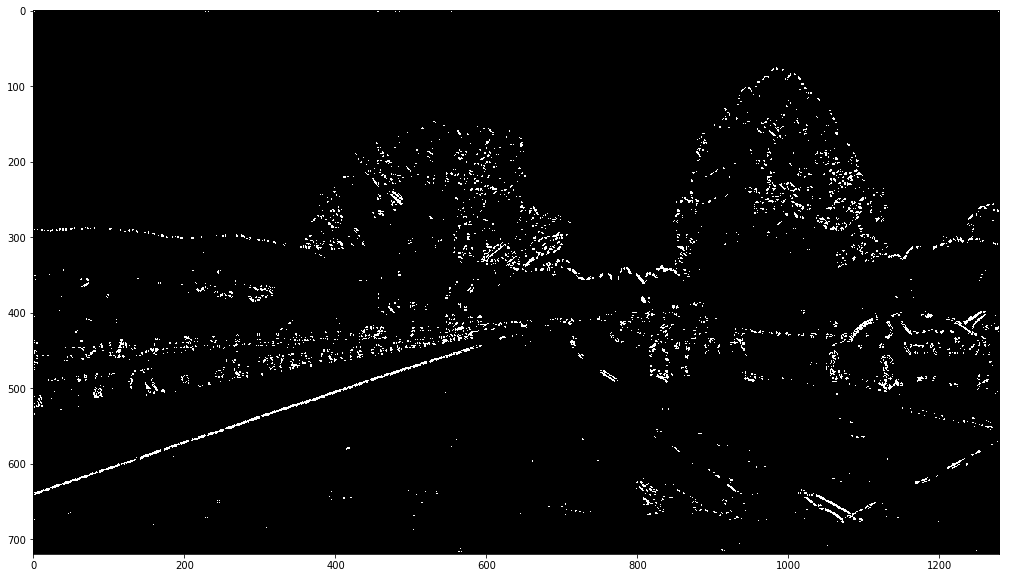

In [88]:
binary_image=compose_all_gray_gradients(test_image,sobel_kernel=5)
plt.figure(figsize=(20,10))
plt.imshow(binary_image,cmap='gray')

In [13]:
def color_gray_gradient_threshold(img,min_threshold,max_threshold):
    hls_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    #gray_grad=abs_sobel_thresh(img,orient='x',thresh_min=30,thresh_max=150)
    gray_grad = compose_all_gray_gradients(img,sobel_kernel=5)
    s_channel=hls_image[:,:,2]
    binary_output = np.zeros_like(gray_grad)
    binary_output[(gray_grad==1) | ((s_channel<max_threshold) & (s_channel>min_threshold)) ]=1
    return binary_output

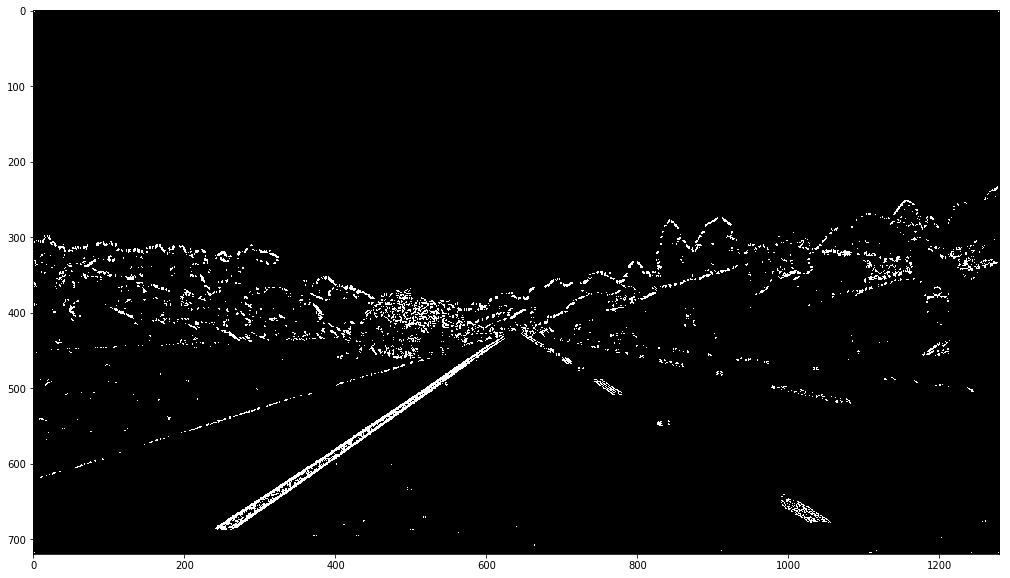

In [24]:
binary_image=color_gray_gradient_threshold(test_image,170,255)
plt.figure(figsize=(20,10))
plt.imshow(binary_image,cmap='gray')

In [14]:
def perspective_transform(img):
    offset = 300
    src = np.float32([[521,504],[769,504],[1056,687],[254,687]])
    #src = np.float32
    dst = np.float32([[300,200],[900,200],[900,720],[300,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped
    

In [15]:
def inv_perspective_transform(img):
    dst = np.float32([[521,504],[769,504],[1056,687],[254,687]])#src and dst are flipped
    src = np.float32([[300,200],[900,200],[900,720],[300,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped

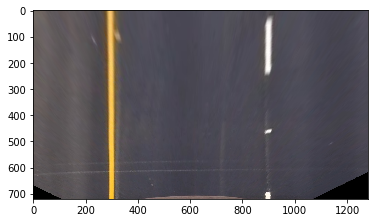

In [27]:
test_image=cv2.imread('/home/carnd/self-driving/advanced-lane-finding/straight_lines1.jpg')
t=perspective_transform(undistort_image(test_image))
t=cv2.cvtColor(t,cv2.COLOR_BGR2RGB)
plt.imshow(t)

In [16]:
def full_pipeline(image):
    binary_image = color_gray_gradient_threshold(image,170,255)
    bird_eye_image= perspective_transform(binary_image)
    return bird_eye_image

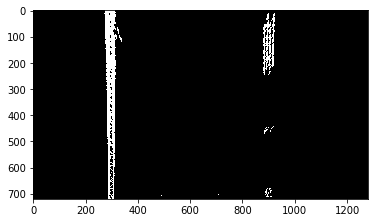

In [29]:
t=perspective_transform(binary_image)
#t=cv2.cvtColor(t,cv2.COLOR_BGR2RGB)
plt.imshow(t,cmap='gray')
#cv2.imwrite(t,)

In [30]:
cv2.imwrite('/home/carnd/self-driving/advanced-lane-finding/binary.jpg',t)

True

In [31]:
t.shape

(720, 1280)

In [17]:
#from lecture notes
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [18]:
def lane_line_confidence(l_center,l_center_confidence,r_center,r_center_confidence):
    if l_center_confidence & r_center_confidence:
        return l_center,r_center
    if l_center_confidence:
        r_center = l_center+600 #not enough pixels found in right lane so use left lane to locate it
        return l_center,r_center
    if r_center_confidence:
        l_center = r_center-600
        return l_center,r_center
    return l_center,r_center
    

In [19]:
#from lecture notes
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    import pdb
    #pdb.set_trace()
    min_pix = 100
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    l_center_confidence = np.max(np.convolve(window,l_sum)) > min_pix
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    r_center_confidence = np.max(np.convolve(window,r_sum)) > min_pix
    l_center,r_center = lane_line_confidence(l_center,l_center_confidence,r_center,r_center_confidence)
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_center_confidence = np.max(conv_signal[l_min_index:l_max_index]) > min_pix
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        r_center_confidence = np.max(conv_signal[r_min_index:r_max_index])>min_pix
        l_center,r_center = lane_line_confidence(l_center,l_center_confidence,r_center,r_center_confidence)
        window_centroids.append((l_center,r_center))

    return window_centroids

In [20]:
def find_window_centroids2(image,window_width, window_height, margin,prev_left,prev_right):
    l_center=prev_left
    r_center = prev_right
    for level in range(0,(int)(image.shape[0]/window_height)):
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_center_confidence = np.max(conv_signal[l_min_index:l_max_index]) > min_pix
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        r_center_confidence = np.max(conv_signal[r_min_index:r_max_index])>min_pix
        l_center,r_center = lane_line_confidence(l_center,l_center_confidence,r_center,r_center_confidence)
        window_centroids.append((l_center,r_center))
    return window_centroids

In [ ]:
test_image=cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
window_centroids = find_window_centroids(full_pipeline(test_image), window_width, window_height, margin)
t=full_pipeline(test_image)

In [ ]:
plt.imshow(test_image)#ignore rgbbgr for now

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(color_gray_gradient_threshold(test_image,170,255),cmap='gray')

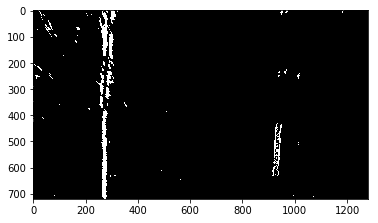

In [39]:
plt.imshow(t,cmap='gray')

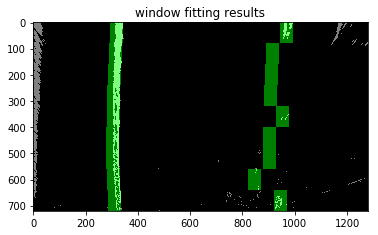

In [23]:
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(t)
    r_points = np.zeros_like(t)

    # Go through each level and draw the windows
    for level in range(0, len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height, t, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, t, window_centroids[level][1], level)
        # Add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255

    # Draw the results
    template = np.array(r_points + l_points, np.uint8)  # add both left and right window pixels together
    zero_channel = np.zeros_like(template)  # create a zero color channel
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)  # make window pixels green
    warpage = 255*np.array(cv2.merge((t, t, t)),
                       np.uint8)  # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 0.5, template, 0.5, 0.0)  # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = 255*np.array(cv2.merge((t, t, t)), np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [74]:
output.shape

(720, 1280, 9)

In [75]:
len(window_centroids)

9

In [104]:
window_centroids

[(268.0, 945.0),
 (268.0, 892.0),
 (246.0, 967.0),
 (233.0, 901.0),
 (304.0, 904.0),
 (261.0, 969.0),
 (260.0, 920.0),
 (257.0, 857.0),
 (273.0, 924.0)]

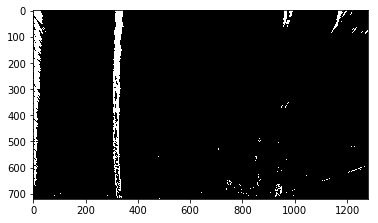

In [120]:
plt.imshow(np.array(255*cv2.merge((t, t, t)), np.uint8))

In [24]:
def find_non_zero_points(binary_image,window_centroids, window_width,window_height):
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    level = 0
    left_lane_indices = []
    right_lane_indices = []
    for centroid in window_centroids:
        y_low = binary_image.shape[0] - level*window_height
        y_high = y_low+window_height
        x_left_low = centroid[0]-window_width/2
        x_left_high = centroid[0] + window_width/2
        x_right_low = centroid[1]-window_width/2
        x_right_high = centroid[1] + window_width/2
        if level==8:
            import pdb
            pdb.set_trace()
        good_left_indices = ((nonzeroy>=y_low) & (nonzeroy<y_high) & (nonzerox>=x_left_low) & (nonzerox<x_left_high)).nonzero()[0]
        good_right_indices = ((nonzeroy>=y_low) & (nonzeroy<y_high) & (nonzerox>=x_right_low) & (nonzerox<x_right_high)).nonzero()[0]
        level += 1
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
    left_lane_inds = np.concatenate(left_lane_indices)
    right_lane_inds = np.concatenate(right_lane_indices)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return (leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds)

In [25]:
leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=find_non_zero_points(full_pipeline(test_image),window_centroids,window_width,window_height)

> <ipython-input-24-cca7a4a4bfc1>(18)find_non_zero_points()
-> good_left_indices = ((nonzeroy>=y_low) & (nonzeroy<y_high) & (nonzerox>=x_left_low) & (nonzerox<x_left_high)).nonzero()[0]
160
80
> <ipython-input-24-cca7a4a4bfc1>(19)find_non_zero_points()
-> good_right_indices = ((nonzeroy>=y_low) & (nonzeroy<y_high) & (nonzerox>=x_right_low) & (nonzerox<x_right_high)).nonzero()[0]
> <ipython-input-24-cca7a4a4bfc1>(20)find_non_zero_points()
-> level += 1
array([], dtype=int64)
942.0
992.0
[(313.0, 946.0), (308.0, 847.0), (305.0, 905.0), (304.0, 904.0), (307.0, 952.0), (309.0, 909.0), (310.0, 910.0), (315.0, 915.0), (320.0, 967.0)]


BdbQuit: 

In [117]:
left_fit,l_res,_,_,_ = np.polyfit(lefty, leftx, 2,full=True)
right_fit,r_res,_,_,_=np.polyfit(righty,rightx,2,full=True)

In [122]:
lefty[lefty>200]

array([640, 640, 640, ..., 237, 238, 239])

In [43]:
len(leftx)

17117

In [111]:
left_fit

array([  5.22932822e-05,  -3.21812041e-02,   3.18466712e+02])

In [99]:
ploty = np.linspace(0, t.shape[0]-1, t.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [101]:
t=full_pipeline(test_image)

(720, 0)

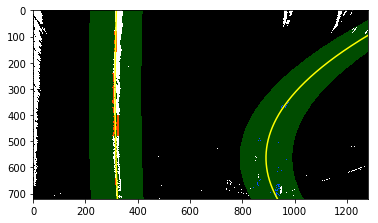

In [102]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((t, t,t))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [43]:
def calc_radius(x,y):
    ym_per_pix = 30/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval=720
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

In [44]:
calc_radius(leftx,lefty)

2441.7172681943589

In [51]:
class Line():
    def __init__(self):
        #self.n = 10
        # was the line detected in the last iteration?
        self.detected = False     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        self.xloc = None
        
    def update(self,x,y):
        try:
            new_fit = np.polyfit(y,x,2)
            
        except:
            self.detected=False
            return
        diff = new_fit-self.current_fit
        if (self.detected & (np.linalg.norm(diff)>5)):
            self.detected = False
            return
        self.detected = True
        if self.best_fit:
            self.best_fit = 0.8*self.best_fit+0.2*new_fit
        else:
            self.best_fit = new_fit
        self.diffs = diff
        self.current_fit = new_fit
        self.radius_of_curvature = calc_radius(x,y)
        self.x_loc = (720**2)*self.best_fit[0] + self.best_fit[1]*720 + self.best_fit[2]
        self.line_base_pos = (640-self.x_loc)*3.7/700
        return 

def update(img,prev_left,prev_right):
    #new img frame comes in..update all values
    binary_image=full_pipeline(img)
    window_width = 50
    window_height = 80
    margin = 100
    if ((prev_left.detected) & prev_right.detected):
        window_centroids = find_window_centroids(binary_image, window_width,window_height, margin,prev_left.xloc,prev_right.xloc)
    else:        
        window_centroids = find_window_centroids(binary_image, window_width,window_height, margin)
    leftx,lefty,rightx,righty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=find_non_zero_points(binary_image,window_centroids,window_width,window_height)
    prev_left.update(leftx,lefty)
    prev_right.update(rightx,righty)
    return

In [74]:
def project_lines(orig_img,left_line,right_line):
    ploty = np.linspace(0, t.shape[0]-1, t.shape[0] )
    left_fit=left_line.best_fit
    right_fit = right_line.best_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(orig_img[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inv_perspective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    return result

In [91]:
left_line=Line()
right_line=Line()

In [92]:
update(test_image,left_line,right_line)

In [93]:
im = project_lines(test_image,left_line,right_line)

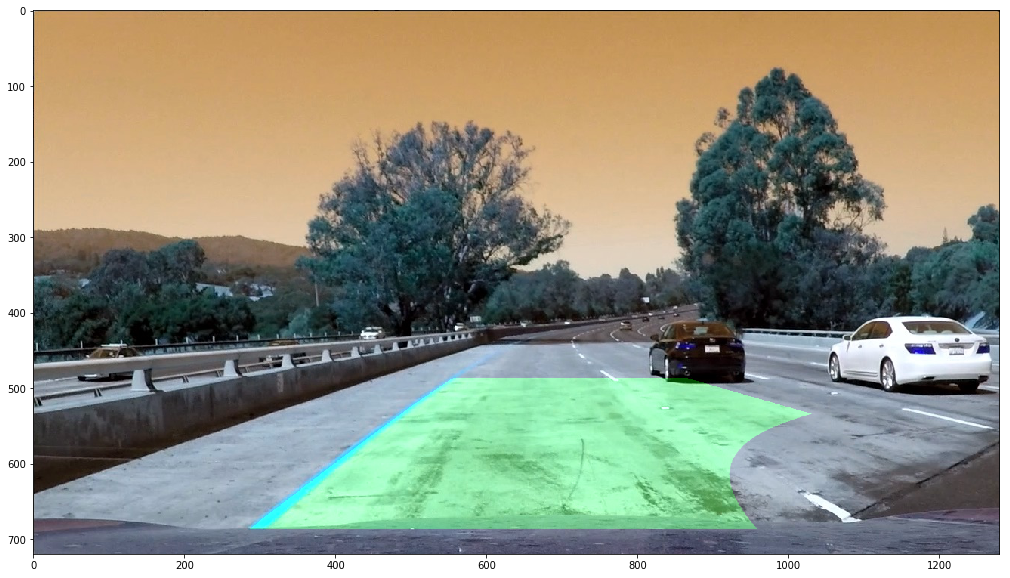

In [94]:
plt.figure(figsize=(20,10))
plt.imshow(im)

In [ ]:
test_image_paths = glob.glob('/home/carnd/CarND-Advanced-Lane-Lines/test_images/*.jpg')

for img_path in test_image_paths:
    img = cv2.imread(img_path)
    print(img_path)
    left_line = Line()
    right_line=Line()
    update(img,left_line,right_line)
    img_lane_lines = project_lines(img,left_line,right_line)
    #plt.figure()
    #plt.imshow(cv2.cvtColor(img_lane_lines,cv2.COLOR_BGR2RGB))

In [83]:
test_image=cv2.imread('/home/carnd/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
binary_image=full_pipeline(test_image)

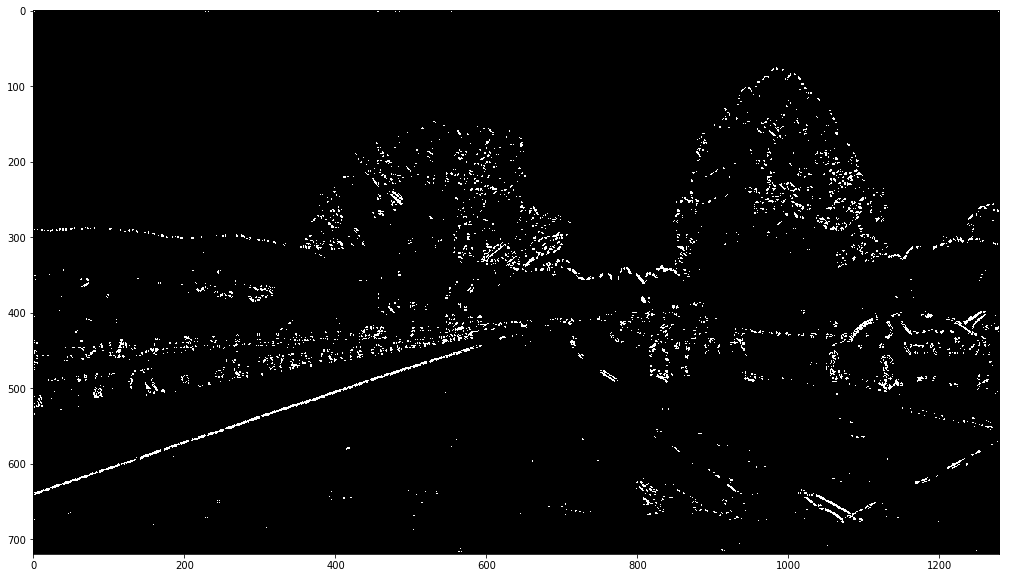

In [90]:
plt.figure(figsize=(20,10))
plt.imshow(binary_image,cmap='gray')

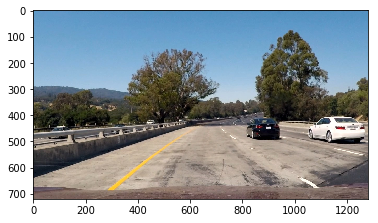

In [87]:
plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))

In [79]:
plt.imshow(test_image)